In [2]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import argparse
import os
import os.path as osp
import tqdm
import torch
import torch.utils.data
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import torchvision
import PIL.Image
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import scipy.misc
import scipy.io as sio
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# HYPERPARAMS
max_iteration=100000
lr=1.0e-14
momentum=0.99
weight_decay=0.0005
interval_validate=4000
batch_size = 10

In [4]:
torch.cuda.set_device(1)
cuda = torch.cuda.is_available()

# to reproduce same results
torch.manual_seed(1337)
if cuda:
    torch.cuda.manual_seed(1337)

In [28]:
#GENERATES GROUND TRUTH FOR POSE POINTS AND PAFS. OUTPUT IS THE CORREPONDING TENSORS WITH C*H*W NOTATION.


def genmat(path,segment):
    W,H = segment.size
    segment = np.array(segment.getdata()).reshape(H,W)
#     print(segment.shape)
    mat = sio.loadmat(path)
    
    #TODO:ADD A POSE FOR HIP CENTER? OR HEURISTIC ON SEGMENT BOUNDS
    
    limbs = [[0,1],[1,2],[2,3],[3,4],[1,5],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13]]
    out = np.zeros((14,H,W))
#     print(out[0].shape)
    pafx = np.zeros((H,W))
    
#     print(pafx.shape)
    pafy = np.zeros((H,W))
    x, y = np.meshgrid(np.arange(W), np.arange(H))
#     y = np.flipud(y)
#     print(x.shape)
    for human in mat['joints'][0]:
        poselist = np.around(human[:,:-1]).astype(np.int64)
        vis = human[:,2]
        #PAF GT
        for limb in limbs:
            p1 = poselist[limb[0],:]
            p2 = poselist[limb[1],:]
            dvec = (p2-p1)/np.linalg.norm(p2-p1)
#             if not (vis[limb[0]]==0 or vis[limb[1]]==0):
            if  ((np.all(p1>0)) and (np.all(p2>0))):
                #APPROX RECON
                print ("yeh vale select hue")
                print (vis[limb[0]],p1,vis[limb[1]],p2)
                vecx = x - p1[0]
                vecy = y - p1[1]
                dot = vecx*dvec[0] + vecy*dvec[1]
                perp2 = vecx**2+vecy**2-dot**2
                boolmat = (dot>0) & (dot<np.linalg.norm(p2-p1)) & (perp2<10) #sigma^2
                pafx[boolmat] = 255#*dvec[0]
                pafy[boolmat] = 255#*dvec[1]
#             else:
#                 mp = np.around((p1+p2)/2.0).astype(np.uint8)
#                 midval = segment[mp[1],mp[0]]
#                 pafx[segment==midval] = dvec[0]
#                 pafy[segment==midval] = dvec[1]
        #POSE GT
        for (i,pose) in enumerate(poselist):
            tmp = 255*np.exp(-((x-pose[0])**2 + (y-pose[1])**2)/(2.0*50.0))
            out[0] = np.maximum(out[0],tmp)
#             print(human[i])
        out[0]=np.maximum(out[0],pafx+pafy)
#         break
    return out,pafx,pafy
    

yeh vale select hue
1.0 [122 119] 1.0 [119 233]
yeh vale select hue
1.0 [119 233] 1.0 [ 37 207]
yeh vale select hue
1.0 [268 119] 1.0 [249 219]
yeh vale select hue
1.0 [249 219] 0.0 [170 229]
yeh vale select hue
0.0 [170 229] 0.0 [188 355]
yeh vale select hue
0.0 [188 355] 1.0 [295 253]
yeh vale select hue
1.0 [249 219] 1.0 [175 229]
yeh vale select hue
1.0 [175 229] 1.0 [203 346]
yeh vale select hue
1.0 [203 346] 1.0 [287 301]


/data/gpu/abhiagwl/miniconda2/envs/abhinav/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


yeh vale select hue
1.0 [331 122] 1.0 [363 190]
yeh vale select hue
1.0 [363 190] 1.0 [428 160]
yeh vale select hue
1.0 [428 160] 1.0 [452 269]
yeh vale select hue
1.0 [452 269] 1.0 [397 225]


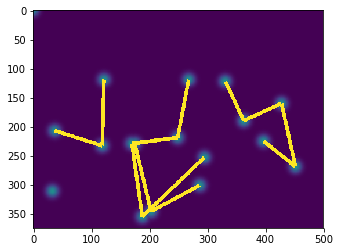

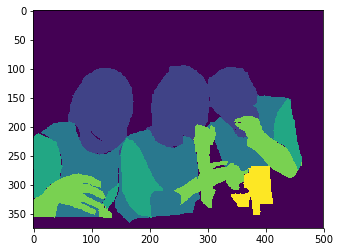

In [29]:
# TESTING
segment = PIL.Image.open('/extra_data/ayushya/pascal_data/pascal_data/SegmentationPart/2008_002251.png')
out,pafx,pafy = genmat('/extra_data/ayushya/pascal_data/pascal_data/PersonJoints/2008_002251.mat',segment)
plt.figure()
plt.imshow(out[0])
# plt.figure()
# plt.imshow(pafx)
plt.figure()
plt.imshow(segment)

In [10]:
class CDATA(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        if(train):
            rfile = root_dir+'pascal_data/pascal_data/train_idnew.txt'
        else :
            rfile = root_dir+'pascal_data/pascal_data/val_idnew.txt'
        ldir = root_dir + 'VOCdevkit/VOC2010/JPEGImages/'
        sdir = root_dir + 'pascal_data/pascal_data/SegmentationPart/'
        pdir = root_dir + 'pascal_data/pascal_data/PersonJoints/'
        self.transform = transform
        self.img = []
        self.seg = []
        self.pose = []
        self.pafx = []
        self.pafy = []
        
        with open(rfile,'r') as f:
            for line in f:
                    line = line[:-1]
                    print(line)
                    image = PIL.Image.open(ldir+line+'.jpg')
                    self.img.append(image.convert('RGB'))
                    segment = PIL.Image.open(sdir+line+'.png')
                    self.seg.append(segment)
                    poset,pafxt,pafyt = genmat(pdir+line+'.mat',segment)
                    self.pose.append(poset)
                    self.pafx.append(pafxt)
                    self.pafy.append(pafyt)
#             PUT DATA IN CORRESPONDING VARS
            
            
#             self.label.append(ord(file_path.split('/')[-2]) - ord('A')) #ord makes A,B,C.. to 0,1,2,.. respectively

            
    def __len__(self):
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        return len(self.img)
        
    def __getitem__(self, idx):
        # idx - the index of the sample requested
        #
        # Open the image correspoding to idx, apply transforms on it and return a tuple (image, label)
        # where label is an integer from 0-9 (since notMNIST has 10 classes)
        if self.transform is None:
            return (self.img[idx],self.seg[idx],self.pose[idx],self.pafx[idx],self.pafy[idx])
        else:
            img_transformed = self.transform(self.img[idx])
#             RETURN VARS
            return (img_transformed,self.seg[idx],self.pose[idx],self.pafx[idx],self.pafy[idx])


In [11]:
composed_transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='/extra_data/ayushya/', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = CDATA(root_dir='/extra_data/ayushya/', train=False, transform=composed_transform) # Supply proper root_dir

print('Size of train dataset: %d' % len(train_dataset))
print('Size of test dataset: %d' % len(test_dataset))


kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}

# Create loaders for the dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


2008_000008
2008_000036
2008_000041


/data/gpu/abhiagwl/miniconda2/envs/abhinav/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/data/gpu/abhiagwl/miniconda2/envs/abhinav/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/data/gpu/abhiagwl/miniconda2/envs/abhinav/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


2008_000096
2008_000109
2008_000128
2008_000132
2008_000141
2008_000142
2008_000143
2008_000144
2008_000176
2008_000191
2008_000199
2008_000202
2008_000207
2008_000217
2008_000226
2008_000235
2008_000236
2008_000237
2008_000252
2008_000255
2008_000259
2008_000260
2008_000266
2008_000275
2008_000283
2008_000284
2008_000289
2008_000290
2008_000297
2008_000311
2008_000313
2008_000316
2008_000330
2008_000338
2008_000342
2008_000343
2008_000346
2008_000364
2008_000365
2008_000371
2008_000380
2008_000392
2008_000393
2008_000415
2008_000416
2008_000421
2008_000422
2008_000426
2008_000432
2008_000435
2008_000436
2008_000442
2008_000443
2008_000445
2008_000447
2008_000448
2008_000455
2008_000461
2008_000480
2008_000493
2008_000499
2008_000514
2008_000527
2008_000531
2008_000540
2008_000544
2008_000545
2008_000548
2008_000552
2008_000561
2008_000563
2008_000572
2008_000578
2008_000583
2008_000584
2008_000588
2008_000607
2008_000613
2008_000615
2008_000628
2008_000636
2008_000645
2008_000646
2008

2008_005271
2008_005294
2008_005295
2008_005297
2008_005315
2008_005324
2008_005336
2008_005365
2008_005395
2008_005408
2008_005412
2008_005414
2008_005429
2008_005484
2008_005494
2008_005500
2008_005519
2008_005527
2008_005549
2008_005558
2008_005567
2008_005570
2008_005600
2008_005609
2008_005610
2008_005616
2008_005625
2008_005641
2008_005650
2008_005682
2008_005698
2008_005707
2008_005737
2008_005742
2008_005758
2008_005761
2008_005791
2008_005794
2008_005832
2008_005850
2008_005855
2008_005867
2008_005902
2008_005921
2008_005923
2008_005937
2008_005972
2008_005976
2008_005991
2008_006032
2008_006039
2008_006064
2008_006076
2008_006078
2008_006096
2008_006102
2008_006121
2008_006124
2008_006129
2008_006135
2008_006145
2008_006152
2008_006181
2008_006188
2008_006195
2008_006215
2008_006235
2008_006250
2008_006253
2008_006256
2008_006257
2008_006265
2008_006272
2008_006273
2008_006289
2008_006295
2008_006317
2008_006331
2008_006370
2008_006390
2008_006404
2008_006410
2008_006421
2008

2010_000922
2010_000942
2010_000954
2010_000970
2010_000974
2010_000991
2010_001020
2010_001092
2010_001094
2010_001106
2010_001111
2010_001112
2010_001113
2010_001120
2010_001131
2010_001142
2010_001143
2010_001148
2010_001184
2010_001210
2010_001212
2010_001224
2010_001245
2010_001250
2010_001254
2010_001288
2010_001289
2010_001312
2010_001329
2010_001337
2010_001338
2010_001385
2010_001397
2010_001399
2010_001401
2010_001408
2010_001413
2010_001430
2010_001431
2010_001458
2010_001480
2010_001533
2010_001551
2010_001552
2010_001580
2010_001619
2010_001638
2010_001649
2010_001650
2010_001674
2010_001689
2010_001729
2010_001748
2010_001756
2010_001762
2010_001785
2010_001810
2010_001817
2010_001846
2010_001850
2010_001856
2010_001870
2010_001923
2010_001940
2010_001941
2010_001960
2010_001978
2010_001993
2010_002018
2010_002039
2010_002044
2010_002070
2010_002107
2010_002121
2010_002127
2010_002139
2010_002154
2010_002166
2010_002179
2010_002185
2010_002191
2010_002221
2010_002226
2010

2008_002146
2008_002155
2008_002167
2008_002169
2008_002172
2008_002176
2008_002179
2008_002185
2008_002191
2008_002193
2008_002199
2008_002212
2008_002222
2008_002231
2008_002241
2008_002250
2008_002259
2008_002272
2008_002283
2008_002305
2008_002312
2008_002314
2008_002321
2008_002322
2008_002324
2008_002328
2008_002330
2008_002347
2008_002356
2008_002366
2008_002374
2008_002378
2008_002384
2008_002403
2008_002404
2008_002414
2008_002419
2008_002424
2008_002428
2008_002436
2008_002439
2008_002445
2008_002446
2008_002451
2008_002456
2008_002470
2008_002477
2008_002483
2008_002485
2008_002494
2008_002495
2008_002499
2008_002502
2008_002510
2008_002512
2008_002523
2008_002526
2008_002527
2008_002540
2008_002542
2008_002558
2008_002564
2008_002567
2008_002576
2008_002579
2008_002588
2008_002590
2008_002598
2008_002599
2008_002603
2008_002606
2008_002610
2008_002616
2008_002631
2008_002639
2008_002640
2008_002643
2008_002645
2008_002652
2008_002653
2008_002670
2008_002677
2008_002678
2008

2008_008755
2008_008758
2009_000017
2009_000063
2009_000067
2009_000072
2009_000074
2009_000078
2009_000102
2009_000149
2009_000157
2009_000165
2009_000169
2009_000171
2009_000182
2009_000183
2009_000219
2009_000247
2009_000249
2009_000257
2009_000282
2009_000283
2009_000288
2009_000291
2009_000305
2009_000309
2009_000337
2009_000378
2009_000397
2009_000411
2009_000418
2009_000421
2009_000430
2009_000453
2009_000455
2009_000456
2009_000457
2009_000461
2009_000496
2009_000511
2009_000519
2009_000542
2009_000550
2009_000552
2009_000563
2009_000606
2009_000615
2009_000637
2009_000661
2009_000674
2009_000676
2009_000704
2009_000719
2009_000724
2009_000726
2009_000727
2009_000730
2009_000763
2009_000783
2009_000820
2009_000821
2009_000825
2009_000843
2009_000856
2009_000858
2009_000865
2009_000890
2009_000896
2009_000897
2009_000901
2009_000934
2009_000995
2009_001000
2009_001011
2009_001024
2009_001026
2009_001030
2009_001054
2009_001084
2009_001106
2009_001120
2009_001121
2009_001155
2009

2010_004889
2010_004901
2010_004921
2010_004951
2010_004952
2010_005005
2010_005026
2010_005031
2010_005044
2010_005046
2010_005049
2010_005079
2010_005118
2010_005141
2010_005148
2010_005166
2010_005188
2010_005222
2010_005226
2010_005243
2010_005245
2010_005252
2010_005284
2010_005293
2010_005314
2010_005327
2010_005338
2010_005346
2010_005369
2010_005374
2010_005379
2010_005405
2010_005410
2010_005467
2010_005480
2010_005493
2010_005515
2010_005527
2010_005532
2010_005538
2010_005542
2010_005543
2010_005572
2010_005582
2010_005606
2010_005610
2010_005620
2010_005626
2010_005654
2010_005657
2010_005666
2010_005681
2010_005697
2010_005709
2010_005733
2010_005764
2010_005768
2010_005838
2010_005871
2010_005884
2010_005897
2010_005907
2010_005936
2010_005991
2010_005997
2010_006000
2010_006004
2010_006010
2010_006037
2010_006051
2010_006061
Size of train dataset: 1696
Size of test dataset: 1797


In [30]:
class suhpos(nn.Module):
    def __init__(self, pretrained_model):
        super(suhpos, self).__init__()
        self.features = pretrained_model.features
        self.poselayer = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(512, 14, kernel_size=(1, 1), stride=(1, 1)),
        )
        self.paflayer = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(512, 13, kernel_size=(1, 1), stride=(1, 1)),
        )
        self.seglayer = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(512, 14, kernel_size=(1, 1), stride=(1, 1)),
        )

    def forward(self, x):
        f = self.features(x)
        pose = self.poselayer(f)
        paf = self.paflayer(f)
        seg = self.seglayer(f)
        return pose,paf,seg


In [9]:
# MODEL
# DEFINE MODEL
# model = torchfcn.models.FCN8s(n_class=21)
vgg19 = models.vgg19(pretrained=True)
model = suhpos(vgg19)
print(model)

resume = 0

start_epoch = 0
start_iteration = 0
if cuda:
    model = model.cuda()


suhpos (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU (inplace)
    (18): MaxPool2d (siz

In [ ]:
# LOSS
def cross_entropy2d(input, target, weight=None, size_average=True):
    # input: (n, c, h, w), target: (n, h, w)
    n, c, h, w = input.size()
    # log_p: (n, c, h, w)
    log_p = F.log_softmax(input)
    # log_p: (n*h*w, c)
#     log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
#     log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
#     log_p = log_p.view(-1, c)
    # target: (n*h*w,)
#     mask = target >= 0
#     target = target[mask]
    loss = F.nll_loss(log_p, target, weight=weight, size_average=False)
    if size_average:
        loss /= mask.data.sum()
    return loss


In [ ]:
# OPTIMIZER
optim = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay)

In [ ]:
# VALIDATION
def validate(iteration):
        val_loss = 0
        label_trues, label_preds = [], []
        for batch_idx, (data, target) in tqdm.tqdm(
                enumerate(test_loader), total=len(test_loader),
                desc='Valid iteration=%d' % iteration, ncols=80,
                leave=False):
            
#             INSERT TARGETS
            if self.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            score = self.model(data)

            loss = cross_entropy2d(score, target)
            if np.isnan(float(loss.data[0])):
                raise ValueError('loss is nan while validating')
            
            val_loss += float(loss.data[0]) / len(data)

#             imgs = data.data.cpu()
#             lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
#             lbl_true = target.data.cpu()
                
#         SAVE IMAGES        
#         out = "val_out/"
#         if not osp.exists(out):
#             os.makedirs(out)
#         out_file = osp.join(out, 'iter%.jpg' % iteration)
#         scipy.misc.imsave(out_file, image)

        val_loss /= len(test_loader)

        

In [ ]:
# TRAINING
def train_model():
    max_epoch = int(math.ceil(1. * max_iter / len(train_loader)))
    for epoch in tqdm.trange(0, max_epoch,
                             desc='Train', ncols=80):
#         INSERT TARGETS
        for batch_idx, (data, target) in tqdm.tqdm( 
                enumerate(train_loader), total=len(train_loader),
                desc='Train epoch=%d' % epoch, ncols=80, leave=False):
            iteration = batch_idx + epoch * len(train_loader)
            
#             VALIDATE
            if iteration % interval_validate == 0:
                validate(iteration)

#             MODIFY FOR TARGETS
            if self.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optim.zero_grad()
#             MODIFY FOR OUTPUTS
            score = model(data)

            loss = cross_entropy2d(score, target)
            loss /= len(data)
            if np.isnan(float(loss.data[0])):
                raise ValueError('loss is nan while training')
            loss.backward()
            optim.step()

#             METRICS
#             metrics = []
#             lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
#             lbl_true = target.data.cpu().numpy()
#             for lt, lp in zip(lbl_true, lbl_pred):
#                 acc, acc_cls, mean_iu, fwavacc = \
#                     torchfcn.utils.label_accuracy_score(
#                         [lt], [lp], n_class=n_class)
#                 metrics.append((acc, acc_cls, mean_iu, fwavacc))
#             metrics = np.mean(metrics, axis=0)

            if iteration >= max_iter:
                break

